<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 3 - Aplicaciones de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Modelos Generativos profundos: VAE (*Variational Autoencoder*) y GAN (*Generative Adversarial Network*).
* Arquitectura encoder-decoder y mecanismo de antención.
* Desafío en donde se aplique todo lo aprendido.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: -
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Modelos Generativos  
[2.](#segundo) *Question-Answering*  
[3.](#tercer) Challenge (*Object Counting*)

*Nota: Para esta actividad, al igual que anteriores, si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*

<a id="primero"></a>
## 1. Modelos Generativos

Las redes neuronales hoy en día han sido aplicados a muchos problemas, de los cuales algunos son necesarios tener un modelo generativo el cual pueda artificialmente sintetizar nuevos ejemplos que sean similares a los originales, éste tipo de aprendizaje se llama **Unsupervised Learning**. Existen diferentes *approaches* para ésto, de los cuales solo veremos 2.

Vamos a trabajar con los datos anteriormente trabajos de MNIST.

```python
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
img_rows, img_cols,channel = X_train.shape[1:]
```


### 1.1 *Variational Autoencoder* (VAE) [[1]](#refs)

Los VAE son una variación a la arquitectura que ya vimos (autoencoder) en donde la codificación y decodificación están conectadas a través de un enfoque bayesiano en donde la codificación aprende los parámetros de alguna distribución de variables latentes de los datos y en donde el decodificador muestrea de ésta distribución de variables latentes para poder generar nuevos datos artificiales $\hat{x}$. Dicho de otra palabras es un autoencoder que aprende el modelo de las variables latentes de los datos.


El enfoque optimizador de los parámetros de la red neuronal $\theta$ es que minimiza la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) agregando una regularización que se impone para que la distribución aprendida de las variables latentes sea de alguna distribución deseada *a priori*.  

$$ Min \ L(q_{\theta}(x\mid z),x) + KL( q_{\theta}(z\mid x) \mid \mid p_{\theta}(z))$$

Con $L$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[5]](#refs), $q_{\hat{\theta}}(x\mid z)$ la recontrucción aleatoria de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori*. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />
 


In [1]:
#Dataset
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2],1))
img_rows, img_cols,channel = X_train.shape[1:]
print("Número de filas en imagenes: ",str(img_rows))
print("Número de columnas en imagenes: ",str(img_cols))
print("Número de canales en imagenes: ",str(channel))

f:\anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Número de filas en imagenes:  28
Número de columnas en imagenes:  28
Número de canales en imagenes:  1


> a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 bloque convolucionales y una bloque *fully conected*, con una distribución Normal multivariada de 2 componentes para las variables latentes. Describa la arquitectura utilizada para el *encoder*.

```python
# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
```

In [2]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model

# input image dimensions
original_img_size = (img_rows, img_cols,channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [11]:
import os    
import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler

from scipy.misc import imread
import _pickle as pickle
import numpy as np
import math

plot_model(encoder, to_file='model-1A.png', show_shapes=True)
Image(filename='model-1A.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

> b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y con 3 bloque de la operación inversa a una convolución (**Convolución transpuesta** [[2]](#refs)), comente cómo ésta trabaja y los parámetros de stride como funcionan. Además se *setea* la distribución de las variables latentes como una distribución Normal multivariada de 2 componentes.

```python
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')
```

In [3]:
from keras.layers import Reshape,Conv2DTranspose,Activation
from keras import backend as K
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid') 

> c) Defina la sección que conecta a estas dos partes a través de un *sampleo* implicito ($g = \mu_{z^{(i)}} + \sigma_{z^{(i)}}\cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilistico/bayesiano. Describa el modelo completo.

```python
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()
```

In [4]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

> d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

```python
from keras import backend as K
# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()
```


In [5]:
from keras import backend as K
# Compute VAE loss
#CUANDO SON DATOS ENTRE 0 Y 1, COMO EN ESTE CASO, SE USA SI O SI BINARY CROSSENTROPY
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

> e) Entrene el modelo definido con los datos de MNIST entre 10 a 15 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

```python
batch_size = ...
epochs =  [10,15]
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))
```

In [6]:
batch_size = 75
#epochs =  [10,15]
epochs =  15
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 116s 2ms/step - loss: 1124.3979 - val_loss: 158.8901
Epoch 2/15
60000/60000 [==============================] - 112s 2ms/step - loss: 155.5325 - val_loss: 151.9110
Epoch 3/15
60000/60000 [==============================] - 112s 2ms/step - loss: 150.6050 - val_loss: 148.7327
Epoch 4/15
60000/60000 [==============================] - 112s 2ms/step - loss: 147.7618 - val_loss: 148.5089
Epoch 5/15
60000/60000 [==============================] - 112s 2ms/step - loss: 145.8533 - val_loss: 146.6110
Epoch 6/15
60000/60000 [==============================] - 112s 2ms/step - loss: 144.3625 - val_loss: 144.1136
Epoch 7/15
60000/60000 [==============================] - 112s 2ms/step - loss: 143.2872 - val_loss: 143.5954
Epoch 8/15
60000/60000 [==============================] - 112s 2ms/step - loss: 142.2354 - val_loss: 142.5899
Epoch 9/15
60000/60000 [==============================] - 111s 2ms/st

> f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_{z^{(i)}}$. Además genere un histograma de la media y la varianza $\sigma_{z^{(i)}}^2$ de las dos componentes. Comente

```python
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
#histogram
```

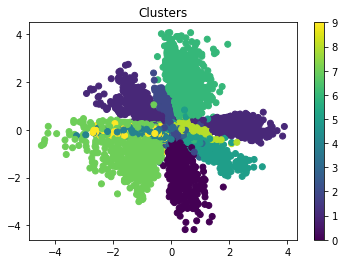

In [10]:
import matplotlib.pyplot as plt
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)

plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("Clusters")
plt.show()
encoder_log_var = Model(x,z_log_var)


In [28]:
first_layer = K.function([encoder.layers[0].input]
                        ,[encoder.layers[-1].output])
output = first_layer([X_test])[0]

ResourceExhaustedError: OOM when allocating tensor with shape[10000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: flatten_1/Shape/_255 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_31_flatten_1/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_1/convolution', defined at:
  File "f:\anaconda2\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "f:\anaconda2\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "f:\anaconda2\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "f:\anaconda2\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "f:\anaconda2\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-7a8be85aab10>", line 15, in <module>
    conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1042, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "f:\anaconda2\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,32,28,28] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_1/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: flatten_1/Shape/_255 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_31_flatten_1/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



IndexError: too many indices for array

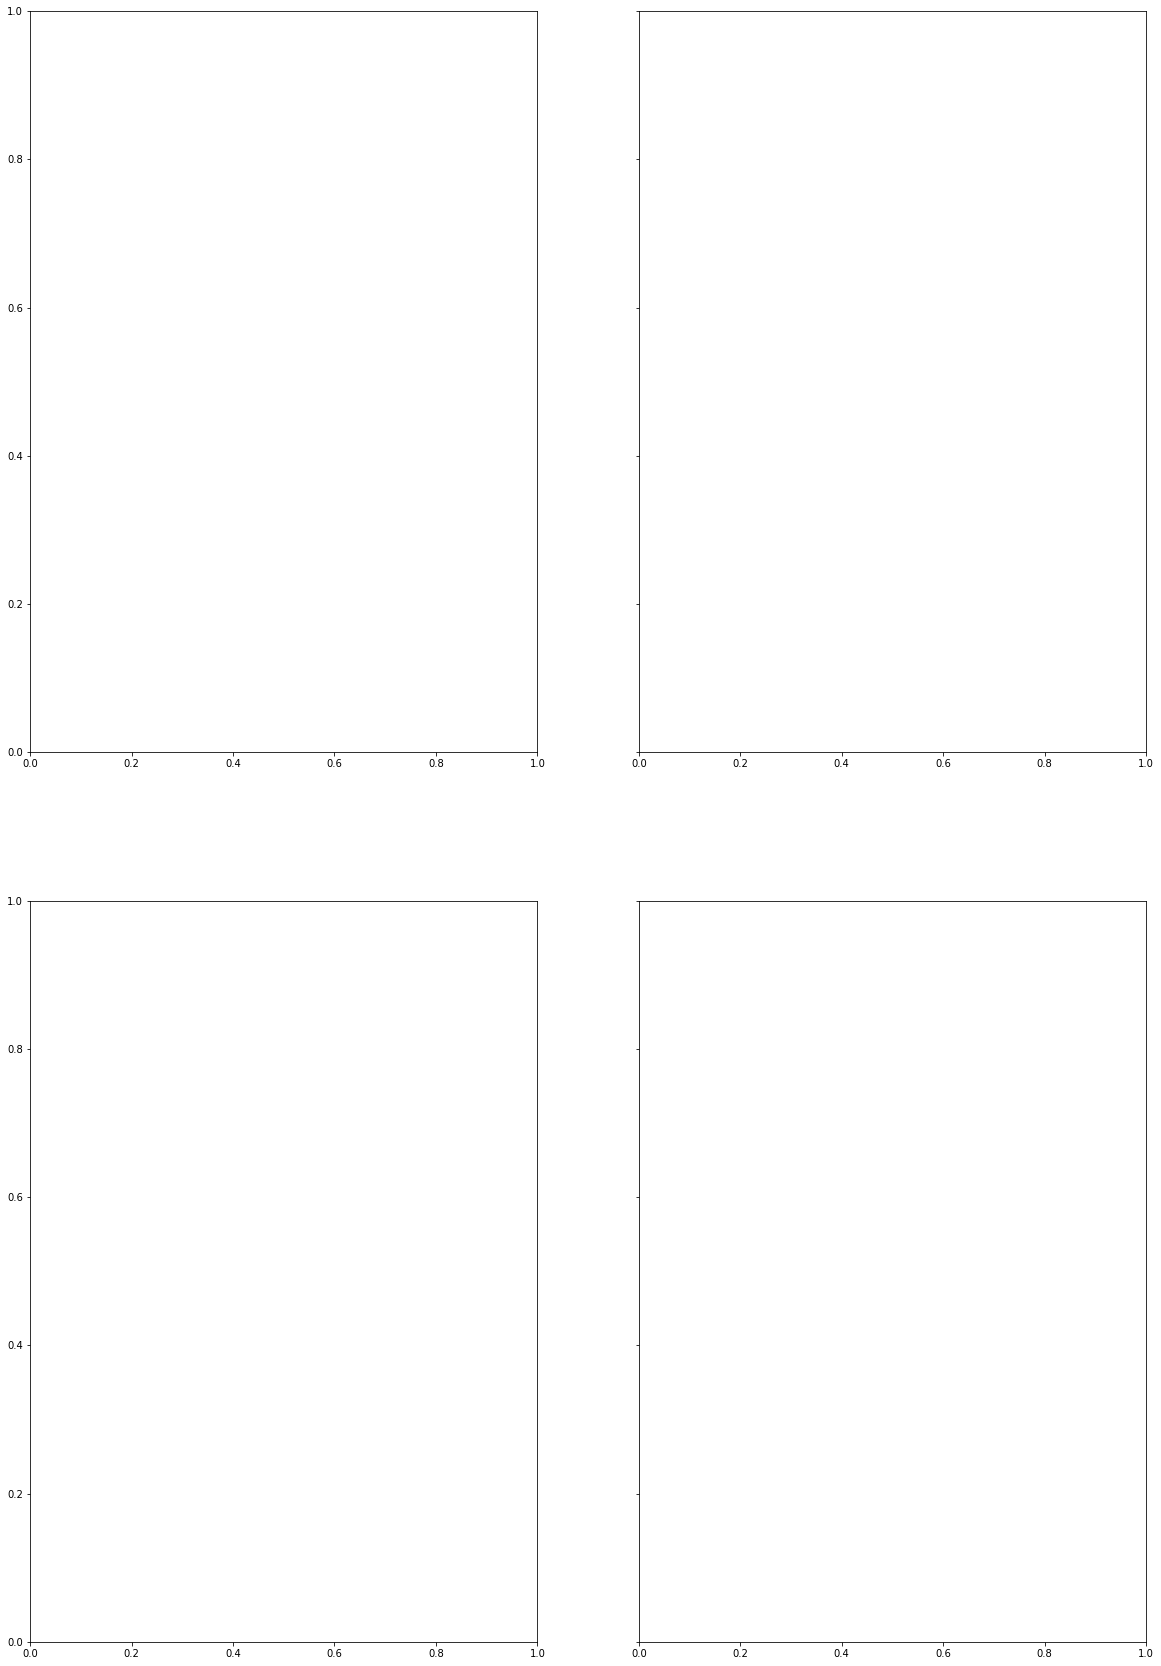

In [15]:
#histogram
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,30), sharey=True)
a,b,c,d  = axes.flatten()

a.hist(np.asarray(z_mean[0])[:], facecolor='green', alpha=0.5)
a.set_xlabel("Media", fontsize=14)
a.set_ylabel("Frecuencia", fontsize=14)
a.set_title('Histograma Media Primera Componente', fontsize=16)


b.hist(np.asarray(z_log_var[0])[:], facecolor='green', alpha=0.5)
b.set_xlabel("Varianza", fontsize=14)
b.set_ylabel("Frecuencia", fontsize=14)
b.set_title('Histograma Varianza Primera Componente', fontsize=16)


c.hist(np.asarray(z_mean[1])[:], facecolor='green', alpha=0.5)
c.set_xlabel("Media", fontsize=14)
c.set_ylabel("Frecuencia", fontsize=14)
c.set_title('Histograma Media Segunda Componente', fontsize=16)


d.hist(np.asarray(z_log_var[1])[:], facecolor='green', alpha=0.5)
d.set_xlabel("Varianza", fontsize=14)
d.set_ylabel("Frecuencia", fontsize=14)
d.set_title('Histograma Varianza Segunda Componente', fontsize=16)

fig.tight_layout()

plt.show()



> g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

```python
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))
```

> h) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida diferente a la Normal y muestre sobre el cómo debiera ser implementada.


> i) Comente sobre si mejora o empeora el desempeño al aumentar la dimensionalidad de las variables latentes $z$, explique.


> j) Vea qué sucede al cambiar algún aspectro estructural de la red (en su arquitectura). Recuerde que la estructura del *decoder* debe ser análoga a la del *encoder. 

### 1.2 *Generative Adversarial Networks* (GAN) [[4]](#refs)


Las GAN son un enfoque distinto de modelo generativo. A pesar de que tiene dos redes conectadas, las tareas que realiza cada una de ella son distintas. Se trata de un modelo adversario en que una red *compite* con la otra. Por un lado se tiene la red discriminadora $D$ que intenta disernir si un dato proviene de los datos reales o fue un dato generado artificialmente. Por otro lado se tiene la red generadora $G$ que intenta generar datos artificialmente de manera que la red discriminadora se confunda, es decir, sea lo más similar a los datos reales. 

<img src="https://oshearesearch.com/wp-content/uploads/2016/07/mnist_gan.png" title="VAE" width="60%" />


El enfoque optimizador de los parámetros de la red neuronal es para $D$ el de maximizar la probabilidad de los datos que provienen de la distribución original minimizando la probabilidad de los datos que provienen del modelo generativo. Mientras que para $G$ es el de maximizzar la probabilidad de que $D$ asigne un dato de $G$ como real, o bien, minimizar la probabilidad de que $D$ asigne un dato de $G$ como corrupto.

$$
min_G \ max_G = E_{x\sim p_{data}(x) }[logD(x)] + E_{z\sim p_z(z)}[log(1-D(G(z))]
$$

Ésto tiene un óptimo teórico que es cuando $p_g = p_{data}$, es decir, cuando el *generador* $G$ logra imitar la distribución de probabilidad de los datos.



> a) Defina al *discriminador* de la GAN como el que se muestra en el código, de 3 bloque convolucionales y una tanda *fully conected*, con los Dropout para evitar *overfitting*. Describa la arquitectura utilizada y cuál es la función de activación seleccionada.

```python
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()
```

> b) Defina al *generador* de la GAN como el que se muestra en el código, con una tanda *fully conected* y 3 bloque convolucionales transpuesta además de agregar *BatchNormalization* entre ellas para tener un aprendizaje más estable. Describa la arquitectura utilizada (siendo del tipo *fully convolutional* puesto que la salida es un arreglo n-dimensional) y el porqué la función de activación de la salida es *sigmoidal*.

```python
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(depth/2, (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(depth/2, (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()
```


> c) Conecte los modelos a través del enfoque adversario, será necesario definir dos modelos debido a que el entrenamiento es iterativo, primero se entrena el discriminador el generador fijo, luego se entrena el generador con el discriminador fijo y así. 

```python
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
```



> d) Entrene el modelo definido con el enfoque iterativo como se nombró, para ésto utilice la función que se presenta que lo realiza de manera manual. Grafique la pérdida *loss* de cada red (el generador y el discriminador/adversario) a través de los pasos de actualización de los pesos ¿Cómo se espera que sean estas curvas de aprendizaje?

```python
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
        return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)
```



> e) Genere nuevos datos artificialmente a través del modelo generador *G* ya entrenado, para esto inicialice aleatoriamente el espacio oculto de dimensiones del generador a través de una distribución Uniforme entre -1 y 1, al igual como fue entrenado. Comente sobre las imágenes generadas y compare con lo realizado con el VAE, en temas de calidad visual y en tiempos de ejecución.

```python
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
```



> f) ¿Qué le parece que resulta más crucial al momento de entrenar las GAN, saber que se tiene un buen generador e intentar mejorar el discriminador o saber que se tiene un buen discriminador e intentar mejorar el generador? en ambos casos para que el generador mejore. Experimente con una de las ideas, modifique el generador o el discriminador e intente generar mejores imágenes artificiales.



> g) ¿Qué pasa al cambiar la distribución latente de los datos $z$? Comente sobre alguna distribución elegida, diferente a la Uniforme, e **implementela** entrenando completamente el modelo.



> h) Comente sobre el efecto de aumentar la dimensionalidad de las variables a generar datos $z$. Compare con lo acontecido con el método generativo VAE.